In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange, tqdm

In [28]:
Bearing_Data_Resampled = pd.read_csv('Bearing_Resampled_Dataset.csv')

In [29]:
Bearing_Data_Resampled.head()

f         e     hmin0     hminL  PSIx th  PSIy th  D0 th  \
0  72.073559  0.371509  0.628491  0.628491      0.0     0.00    0.0   
1  72.077757  0.371411  0.652290  0.604727      0.0     0.05    0.0   
2  72.057533  0.371207  0.675995  0.580942      0.0     0.10    0.0   
3  72.012865  0.370896  0.699544  0.557163      0.0     0.15    0.0   
4  71.943629  0.370480  0.722856  0.533414      0.0     0.20    0.0   

   Misaligned  
0           0  
1           0  
2           1  
3           1  
4           1

In [30]:
# Normalize the data
features = Bearing_Data_Resampled.columns[:-1]
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_data = scaler.fit_transform(Bearing_Data_Resampled[features])
normalized_data = pd.DataFrame(normalized_data, columns=features)
normalized_data_full = pd.concat([pd.DataFrame(normalized_data, columns=features), Bearing_Data_Resampled.iloc[:, -1]], axis=1)

In [31]:
normalized_data

f         e     hmin0     hminL   PSIx th   PSIy th  D0 th
0     0.794830 -0.468693 -0.841303  1.000000 -1.000000 -1.000000   -1.0
1     0.795886 -0.474806 -0.679788  0.867813 -1.000000 -0.800000   -1.0
2     0.790797 -0.487649 -0.518913  0.735511 -1.000000 -0.600000   -1.0
3     0.779556 -0.507165 -0.359094  0.603247 -1.000000 -0.400000   -1.0
4     0.762134 -0.533268 -0.200888  0.471142 -1.000000 -0.200000   -1.0
...        ...       ...       ...       ...       ...       ...    ...
2569 -0.085537  0.344204 -0.895762  0.900206 -0.969380 -0.969380    0.4
2570  0.252738 -0.024044 -0.834179  0.915026 -1.000000 -0.930451    0.0
2571  0.397399 -0.160867 -0.665347  0.798038 -0.818453 -0.800000   -0.2
2572 -0.654230  0.992489 -0.851336  0.748049 -1.000000 -0.808548    1.0
2573  0.393466 -0.149674 -0.870162  0.966256 -0.978244 -1.000000   -0.2

[2574 rows x 7 columns]

In [58]:
target_col = "target"
target = normalized_data.pop('Misaligned')

In [32]:
# Assign variables for training while disregarding the Label column
X = normalized_data_full.drop(columns = ['Misaligned']).copy().values
y = normalized_data_full['Misaligned'].values

In [33]:
# OOP class for our GAN
class SPARGAN():
    def __init__(self, latent_dim=100, hidden_layers=[512, 256], d_in = 8): 
        self.hidden_layers = hidden_layers
        self.latent_dim = latent_dim
        self.d_in = d_in
    def layer(x, layer_size):
        x = Dense(layer_size, activation=LeakyReLU(alpha=0.2))(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dropout(0.75)(x)
        return x 
    
    # Generator Model
    def build_generator(self):
        input_layer = Input(shape=(self.latent_dim,))
        x = input_layer
        
        for layer_size in self.hidden_layers:
            x = SPARGAN.layer(x, layer_size)
            
        x = Dense(self.d_in, activation='relu')(x) 

        model = Model(input_layer, x)
        self.generator = model
        
    # Discrminator Model 
    def build_discriminator(self):
        input_layer = Input(shape=(self.d_in,))
        x = input_layer
        for layer_size in reversed(self.hidden_layers):
            x = SPARGAN.layer(x, layer_size)
            
        x = Dense(1, activation='sigmoid')(x) # sigmoid - binary classification

        model = Model(input_layer, x)
        self.discriminator = model
        
    def synthesize(self, diff):     #diff: number of samples to be generated
        lst = []
        while len(lst) <= diff-1:
            z = np.random.randn(100, self.latent_dim)
            genz = self.generator.predict(z)
            for i in range(len(z)):
                lab = genz[i, -1]
                if lab > 0 and np.isfinite(lab):
                    if len(lst) <= diff-1:
                        genz[i, -1] = 1
                        lst.append(genz[i, :])
                    else:
                        break
                        
        np.reshape(lst, (1535, 8)).shape     #8 = d_in/number of columns. 1535??
        
        # merge fake with original
        synthetic_data = np.reshape(lst, (1535, 8))
        synthetic_data = pd.DataFrame(synthetic_data, columns = [f'F{i}' for i in range(1, 7)]+["Misaligned"])
        return synthetic_data
    
    #fit model
    def fit(self, df, batch_size=32, epochs=1000, plot_loss=False):
        # Compile both models in preparation for training

        # Build and compile the discriminator
        self.build_discriminator()
        self.discriminator.compile(
            loss='binary_crossentropy',
            optimizer=Adam(0.0002, 0.5),
            metrics=['accuracy']
        )

        # Build and compile the combined model 
        self.build_generator()

        # Create and input to represent noise sample from latent space
        z = Input(shape=(self.latent_dim))

        # Pass noise through generator to get an image
        row = self.generator(z)

        # Make sure only the generator is trained
        self.discriminator.trainable = False

        # The true output is fake, but we label them real
        fake_pred = self.discriminator(row)

        # Create the combined model object
        combined_model = Model(z, fake_pred)

        # Compile the combined model
        combined_model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(0.002, 0.5)
        )

        # Train the GAN 

        # Create batch labs to use when calling train_on_batch
        ones = np.ones(batch_size)
        zeros = np.zeros(batch_size)

        # Store the losses
        d_losses = []
        g_losses = []

        # Main training loop
        for epoch in trange(epochs):
            ###########################
            ### Train Discriminator ###
            ###########################

            # Select a random batch of images
            idx = np.random.randint(0, df.values.shape[0], batch_size)
            real_rows = df.values[idx]

            # Generate fake images
            noise = np.random.randn(batch_size, self.latent_dim)
            fake_rows = self.generator.predict(noise)

            # Train the discriminator
            # both loss and accuracy are returned
            d_loss_real, d_acc_real = self.discriminator.train_on_batch(real_rows, ones)
            d_loss_fake, d_acc_fake = self.discriminator.train_on_batch(fake_rows, zeros)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)
            d_acc = 0.5 * (d_acc_real + d_acc_fake)

            ###########################
            ##### Train Generator #####
            ###########################  

            noise = np.random.randn(batch_size, self.latent_dim)
            g_loss = combined_model.train_on_batch(noise, ones)

            # Save the losses
            d_losses.append(d_loss)
            g_losses.append(g_loss)

            if epoch % 100 == 0:
                print(f'epoch: {epoch + 1}/{epochs}, d_loss: {d_loss: .2f}, d_acc: {d_acc: .2f}, g_loss: {g_loss:.2f}')

        
        if plot_loss:
            plt.plot(d_losses, label='discriminator_loss') 
            plt.plot(g_losses, label='generator_loss')
            plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 71ms/step
epoch: 1/1000, d_loss:  1.39, d_acc:  0.47, g_loss: 0.73
1/1 [==============================] - 0s 16ms/step
epoch: 101/1000, d_loss:  1.38, d_acc:  0.36, g_loss: 4.88
1/1 [==============================] - 0s 24ms/step
epoch: 201/1000, d_loss:  1.22, d_acc:  0.52, g_loss: 3.38
1/1 [==============================] - 0s 24ms/step
epoch: 301/1000, d_loss:  1.04, d_acc:  0.42, g_loss: 1.57
1/1 [==============================] - 0s 24ms/step
epoch: 401/1000, d_loss:  0.81, d_acc:  0.48, g_loss: 1.02
1/1 [==============================] - 0s 16ms/step
epoch: 501/1000, d_loss:  0.77, d_acc:  0.61, g_loss: 0.85
1/1 [==============================] - 0s 16ms/step
epoch: 601/1000, d_loss:  0.85, d_acc:  0.41, g_loss: 0.91
1/1 [==============================] - 0s 24ms/step
epoch: 701/1000, d_loss:  0.78, d_acc:  0.50, g_loss: 0.86
1/1 [==============================] - 0s 18ms/step
epoch: 801/1000, d_loss:  0.75, d_acc:  0.50, g_loss: 0.80
1/1

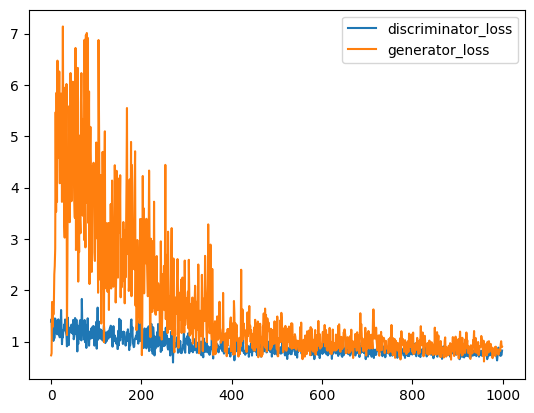

In [34]:
# Train the model
model = SPARGAN()
model.fit(normalized_data_full, plot_loss=True)

In [37]:
# Count the number of ones and zeroes
zeroes, ones = normalized_data_full['Misaligned'].value_counts()
print(f'Zeros: {zeroes} Ones: {ones}')
diff = 5

Zeros: 1287 Ones: 1287


In [ ]:
synthetic_data = model.synthesize(diff)

4/4 [==============================] - 0s 65ms/step
